## Import the required modules

In [17]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA

import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')

## Load the data

In [18]:
data = pd.read_csv('air-traffic-prediction/AirtrafficA4.csv')
data['PASSENGERS CARRIED'] = pd.to_numeric(data['PASSENGERS CARRIED'].str.replace(',', ''))
data

,AIRLINE,YEAR,MONTH,TOTAL DEPARTURES,HOURS FLOWN,KILOMETRE FLOWN,PASSENGERS CARRIED,AVAILABLE SEAT KILOMETRE (IN THOUSAND),FREIGHT CARRIED (IN TONNE),MAIL CARRIED (IN TONNE)
0,A007,2023,JAN,"47,977","83,764","41,827",6847384.0,"78,32,254","16,881.70","2,043.5"
1,A007,2023,FEB,"44,905","77,936","39,121",6741948.0,"73,36,614","17,439.30","2,086.7"
2,A007,2023,MAR,"50,389","87,296","43,793",7317288.0,"82,15,681","20,208.40","2,310.1"
3,A007,2023,APR,"48,752","84,232","42,615",7406440.0,"80,05,648","19,432.80","2,102.9"
4,A007,2023,MAY,"50,956","87,917","44,505",8109626.0,"83,75,201","24,165.10","2,102.4"
...,...,...,...,...,...,...,...,...,...,...
123,A007,2013,AUG,"12,278","21,571","11,884",1531406.0,"21,39,007","9,600.00",0
124,A007,2013,SEP,"12,185","21,281","11,749",1378691.0,"21,14,792","8,492.00",0
125,A007,2013,OCT,"12,780","22,345","12,296",1510184.0,"22,13,139","9,111.00",0
126,A007,2013,NOV,"12,357","21,837","11,904",1467763.0,"21,42,765","7,185.00",0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   AIRLINE                                 128 non-null    object 
 1   YEAR                                    128 non-null    int64  
 2   MONTH                                   128 non-null    object 
 3   TOTAL DEPARTURES                        127 non-null    object 
 4   HOURS FLOWN                             127 non-null    object 
 5   KILOMETRE FLOWN                         127 non-null    object 
 6   PASSENGERS CARRIED                      127 non-null    float64
 7   AVAILABLE SEAT KILOMETRE (IN THOUSAND)  127 non-null    object 
 8    FREIGHT CARRIED (IN TONNE)             127 non-null    object 
 9   MAIL CARRIED (IN TONNE)                 126 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 10.1+ KB


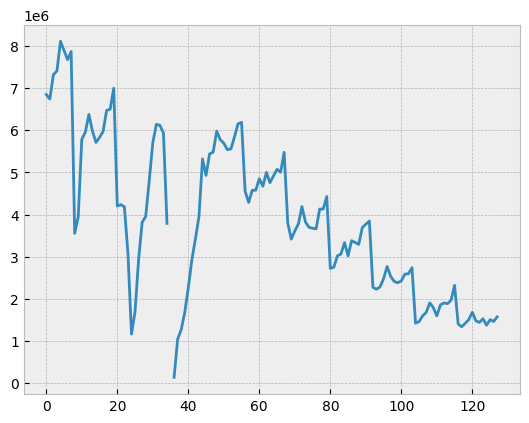

In [20]:
plt.plot(data['PASSENGERS CARRIED'])

##### The rows in the dataset need to be sorted in ascending order of time starting from 2013 JAN to 2023 AUG

<Axes: xlabel='YEAR_MONTH'>

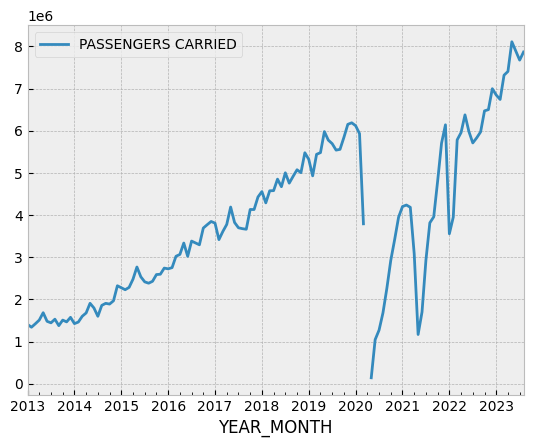

In [21]:
data["YEAR_MONTH"] = pd.to_datetime(data['YEAR'].astype(str) + '-' + data['MONTH'].str[:3] + '-01', format='%Y-%b-%d')
data.set_index('YEAR_MONTH', inplace=True)
data = data.sort_values('YEAR', kind='mergesort')
data.plot(y='PASSENGERS CARRIED')

### Augmented Dicky-Fuller Test
In statistics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The presence of a unit root indicates that the time series is not stationery and its absence indicates that the time series is stationery.

In [22]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1] # approximate value of p returned by adfuller 
    ts_ax.set_title('Air passengers vs Time \n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

(104,)


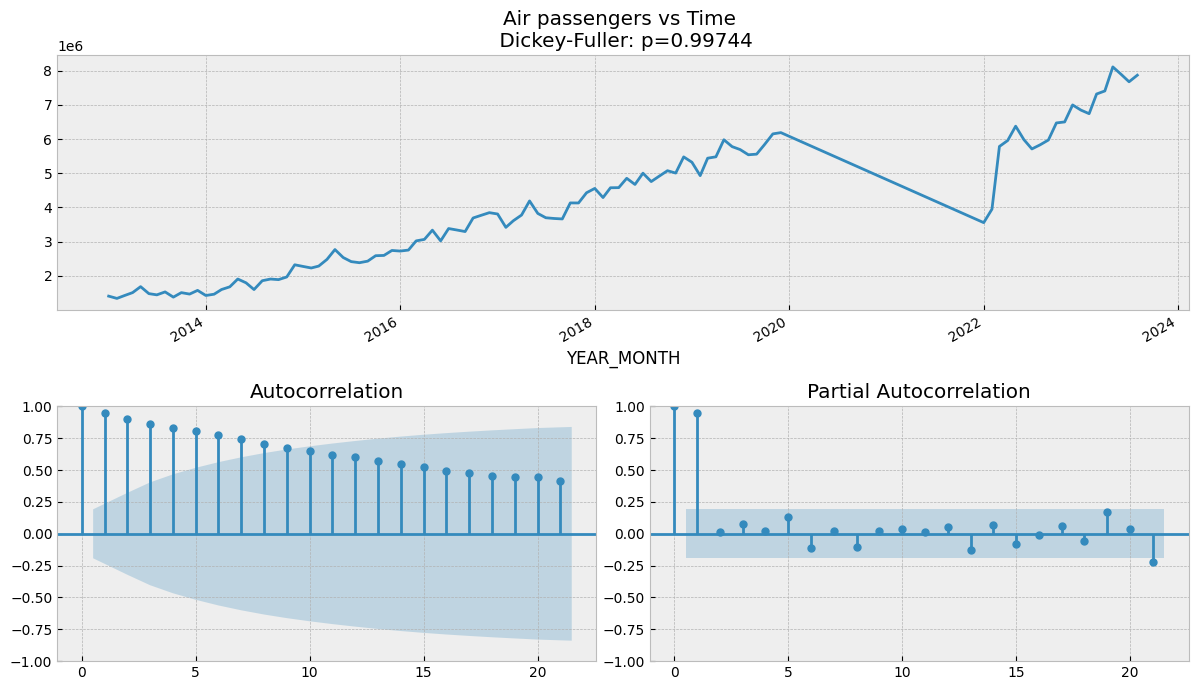

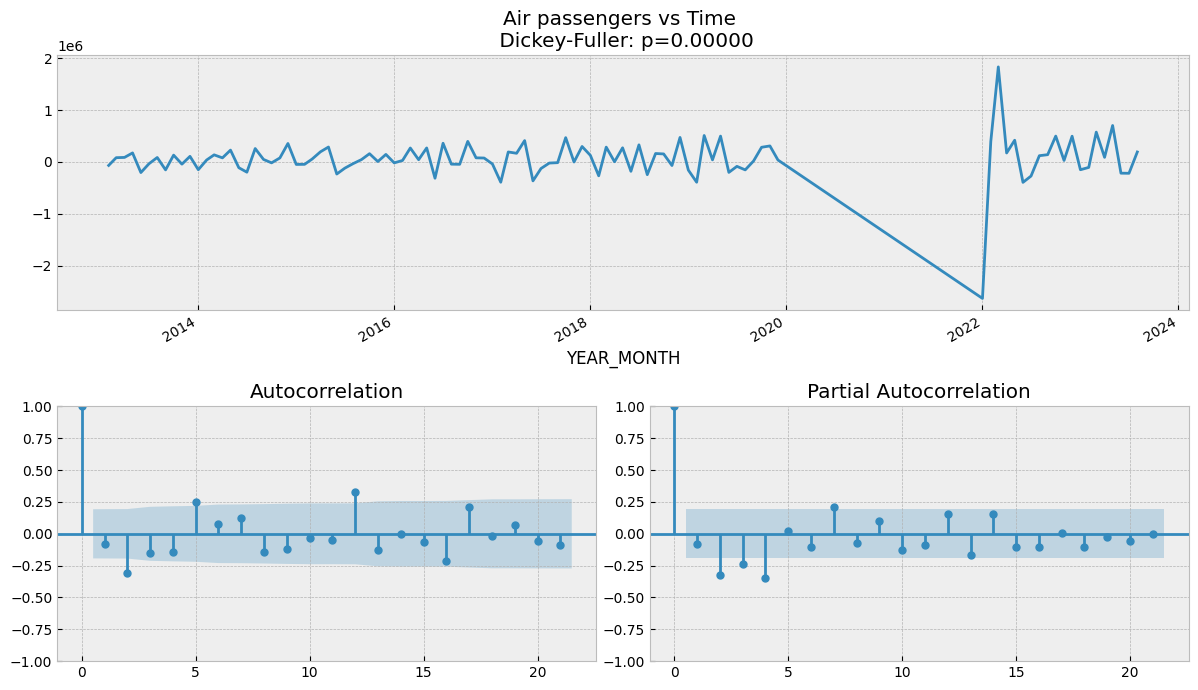

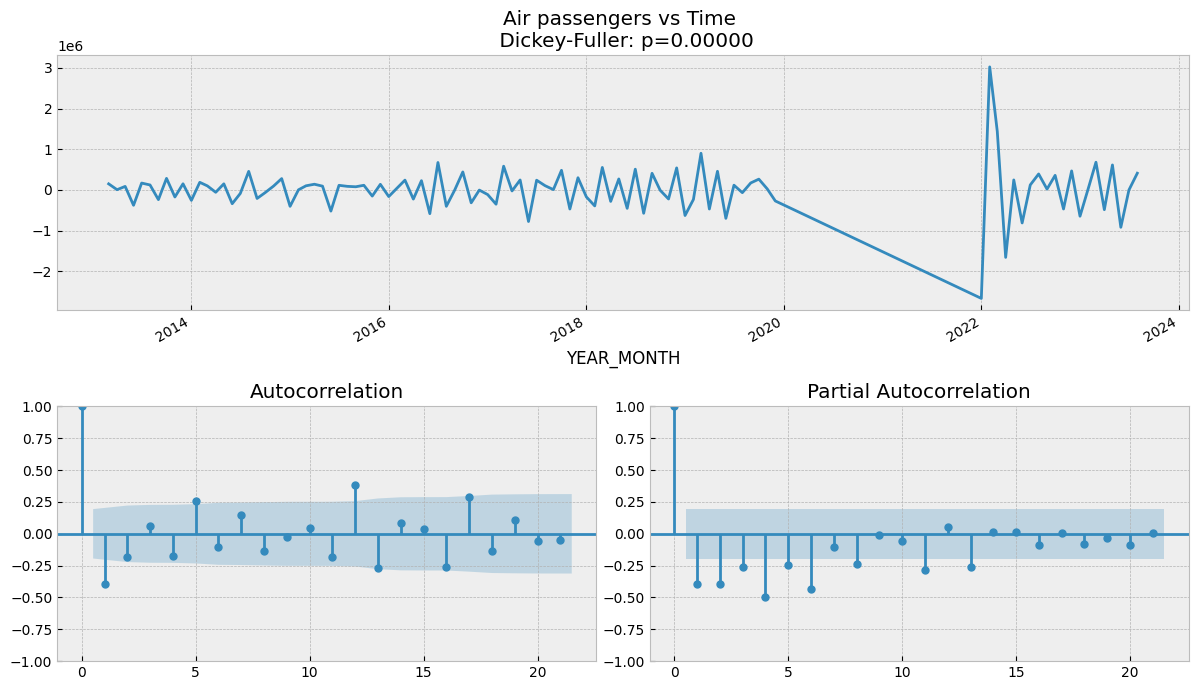

In [23]:
pass_ = data.drop(data[data['YEAR'] == 2020].index).dropna()
pass_ = pass_.drop(pass_[pass_["YEAR"] == 2021].index)['PASSENGERS CARRIED'].dropna()
tsplot(pass_)
print(pass_.shape)

pass_diff = (pass_ - pass_.shift(1)).dropna()
tsplot(pass_diff)

pass_diff_2 = (pass_diff - pass_diff.shift(1)).dropna()
tsplot(pass_diff_2)

Removing the period from 2020 and 2021 due to the high irregularity in the values in that period, possibly because of covid, we trained our model on this dataset but that wasn't so good. So it is not included in this file. Plots for d = 0, d = 1 and d = 2 respectively for this dataset are given above

(127,)


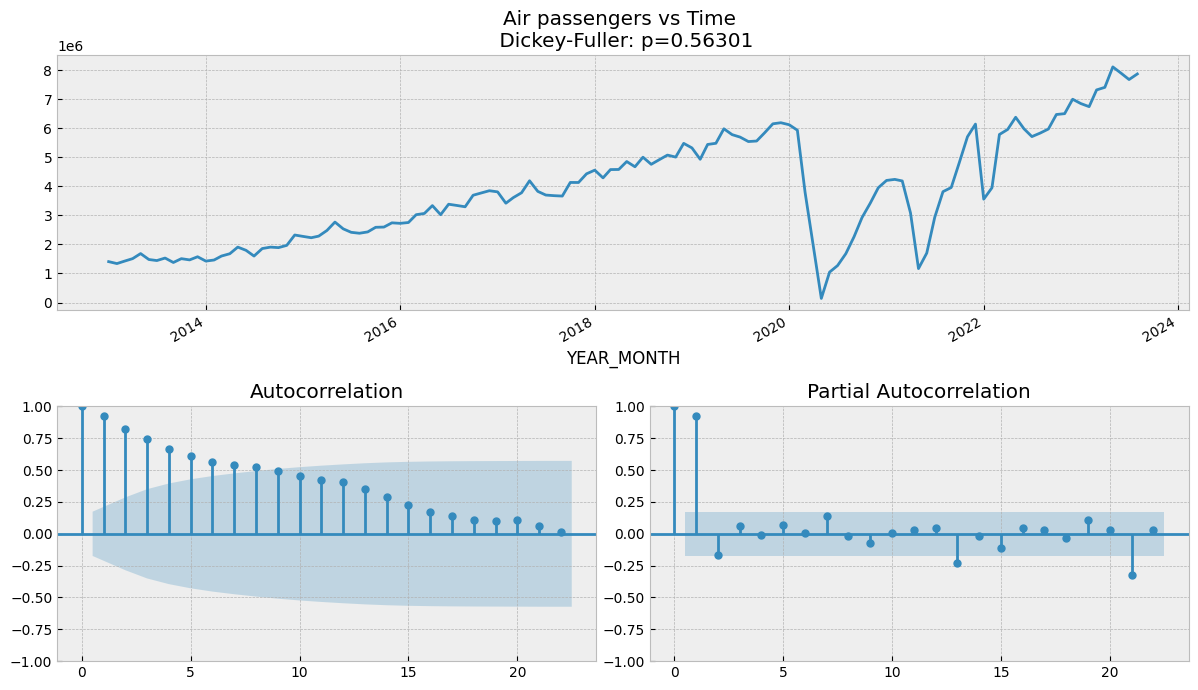

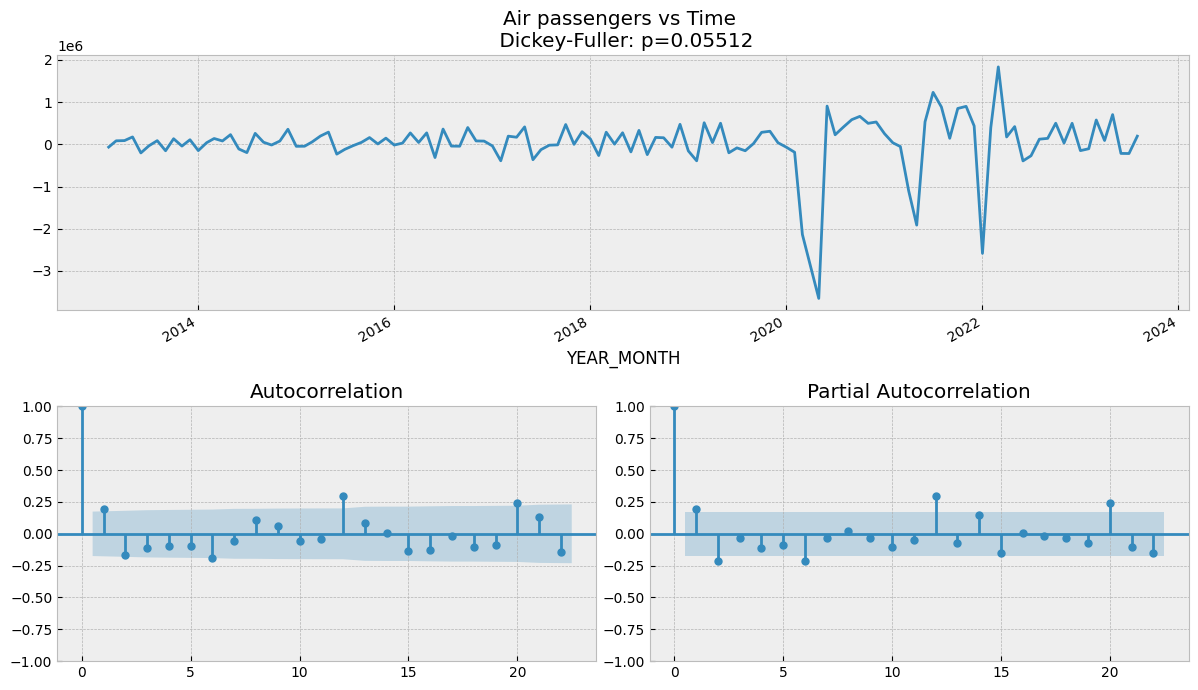

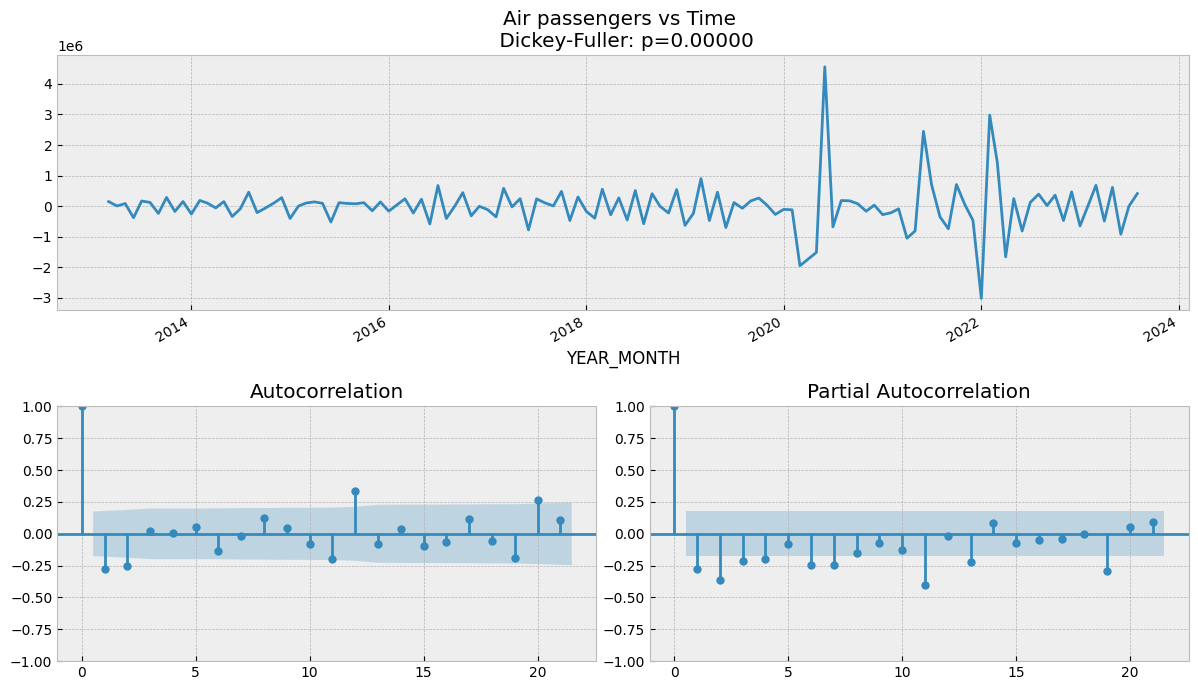

In [24]:
passenger = data['PASSENGERS CARRIED'].dropna()
tsplot(passenger)
print(passenger.shape)

passenger_diff = (passenger - passenger.shift(1)).dropna()
tsplot(passenger_diff)

passenger_diff_2 = (passenger_diff - passenger_diff.shift(1)).dropna()
tsplot(passenger_diff_2)

 Here I have plotted the original time series (d = 0), differenced time series (d = 1) and double differenced time series (d = 2). The Dickey-Fuller p value is 0 for the double differenced time series. Thus I have used AutoARIMA to predict the next 12 values for this time series

#### Fitting the doubly differenced time series on the AutoARIMA model

In [25]:
forecaster = AutoARIMA(seasonal=True, start_P=0, max_P=5, start_Q=0, max_Q=5, suppress_warnings=True)
passenger_diff_2.index = passenger_diff_2.index.astype(int)
forecaster.fit(passenger_diff_2)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -1841.096
Date:                Sun, 27 Oct 2024   AIC                           3692.192
Time:                        22:39:47   BIC                           3706.334
Sample:                             0   HQIC                          3697.937
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -719.4181   2214.247     -0.325      0.745   -5059.262    3620.426
ar.L1          0.2384      0.068      3.496      0.000       0.105       0.372
ar.L2         -0.1977      0.093     -2.136      0.033      -0.379      -0.016
ma.L1         -0.9872      0.086    -11.416      0.000      -1.157      -0.818
sigma2      4.605e+11   3.29e-05    1.4e+16      0.000    4.61e+11    4.61e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               673.84
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              28.31   Skew:                            -2.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.6e+31. Standard errors may be unstable.
"""

### Forecasting the next 12 values

In [26]:
fh = np.arange(12) + 1
forecast = forecaster.predict(fh=fh)
print(forecast)
coverage = 0.9
forecast_int = forecaster.predict_interval(fh=fh, coverage=coverage)['PASSENGERS CARRIED'][coverage]

1690848000000000001    -81822.063801
1690848000000000002   -101455.263534
1690848000000000003     -8728.836489
1690848000000000004     17261.462768
1690848000000000005      5122.149422
1690848000000000006     -2911.513044
1690848000000000007     -2426.452520
1690848000000000008      -722.206633
1690848000000000009      -411.794769
1690848000000000010      -674.787833
1690848000000000011      -798.872689
1690848000000000012      -776.452273
Name: PASSENGERS CARRIED, dtype: float64


##### These are the 12 predicted values for the double differenced time series. These can now be used to find the predictions for the original time series

##### The predicted values from the AutoARIMA model for the doubly differenced time series have been used to find the required values for the original time series
For d = 2, $$y_t^{''} = y_t - 2y_{t-1} + y_{t-2}$$
Thus the equation for finding the predicted values for the original time series can be found by using the formula given below:
$$y_t = y_t^{''} + 2y_{t-1} - y_{t-2}$$

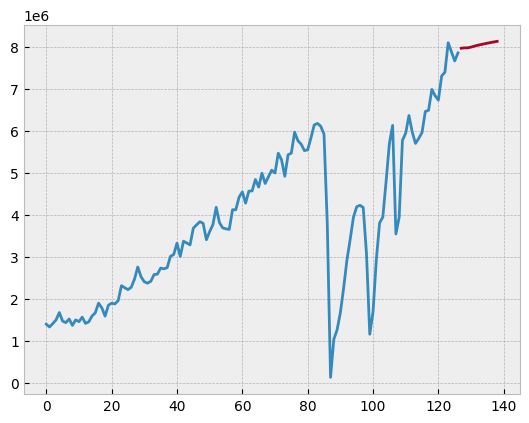

In [27]:
pass_index_reset = passenger_diff_2.reset_index(drop=True)
forecast_index_reset = forecast.reset_index(drop=True)
pass_index_reset = np.array(pass_index_reset)
forecast_index_reset = np.array(forecast_index_reset)

for i in range(len(forecast_index_reset)):
	passenger = np.append(passenger, [forecast_index_reset[i] + 2*passenger[-1] - passenger[-2]])

x1 = np.arange(0, passenger.shape[0] - forecast_index_reset.shape[0], 1)
x2 = np.arange(passenger.shape[0] - forecast_index_reset.shape[0], passenger.shape[0], 1)

plt.plot(x1, passenger[:-forecast_index_reset.shape[0]])
plt.plot(x2, passenger[-forecast_index_reset.shape[0]:])

In [28]:
def make_dataframe(forecast):
	'''
		Converts the forecasted data into a pandas dataframe
		Args:
			forecast: The numpy array of the forecasted data
		Returns:
			forecast_df: The forecasted data in a pandas dataframe
	'''
	forecast_df = pd.DataFrame(forecast, columns=['PASSENGERS CARRIED'])
	forecast_df['YEAR_MONTH'] = ('2023 SEP', '2023 OCT', '2023 NOV', '2023 DEC', '2024 JAN', '2024 FEB', '2024 MAR', '2024 APR', '2024 MAY', '2024 JUN', '2024 JUL', '2024 AUG')
	forecast_df = forecast_df.reindex(columns = ['YEAR_MONTH', 'PASSENGERS CARRIED'])
	return forecast_df

In [29]:
forecast_df = make_dataframe(passenger[-forecast_index_reset.shape[0]:])
forecast_df.to_csv('submission.csv', index=False)
forecast_df

,YEAR_MONTH,PASSENGERS CARRIED
0,2023 SEP,7.977806e+06
1,2023 OCT,7.986898e+06
2,2023 NOV,7.987260e+06
3,2023 DEC,8.004885e+06
4,2024 JAN,8.027631e+06
5,2024 FEB,8.047466e+06
6,2024 MAR,8.064875e+06
7,2024 APR,8.081561e+06
8,2024 MAY,8.097835e+06
9,2024 JUN,8.113435e+06


,PASSENGERS CARRIED
YEAR_MONTH,
2013-01-01,1.408012e+06
2013-02-01,1.341210e+06
2013-03-01,1.423569e+06
2013-04-01,1.511094e+06
2013-05-01,1.685168e+06
...,...
2024-04-01,8.081561e+06
2024-05-01,8.097835e+06
2024-06-01,8.113435e+06


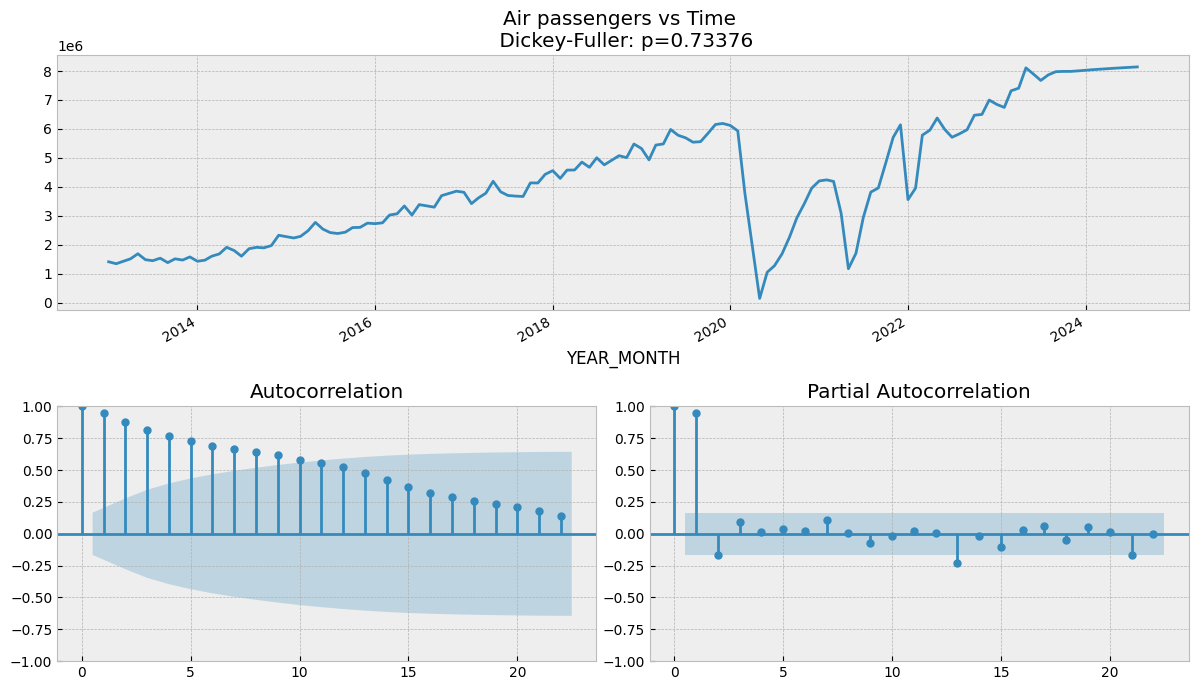

In [30]:
passenger_ts = pd.DataFrame()
passenger_ts['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED']
passenger_ts['YEAR_MONTH'] = data['YEAR'].astype(str) + ' ' + data['MONTH'].str[:3]
passenger_ts.reset_index(drop=True, inplace=True)
passenger_ts = passenger_ts.reindex(columns = ['YEAR_MONTH', 'PASSENGERS CARRIED'])
passenger_ts = pd.concat([passenger_ts, forecast_df], ignore_index=True)
passenger_ts['YEAR_MONTH'] = pd.to_datetime(passenger_ts['YEAR_MONTH'].astype(str) + " 01", format='%Y %b %d')
passenger_ts.set_index('YEAR_MONTH', inplace=True)
tsplot(passenger_ts.dropna()['PASSENGERS CARRIED'])
passenger_ts